In [25]:
import re
import os 
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from scipy.signal import find_peaks

In [84]:
#读取单个的PE loop的文件
df = pd.read_csv(r'C:\PhD-Zipeng\Research projects\PUND\1 - Copy.txt',delimiter='\t',encoding= 'unicode_escape')
df.head(10)

,Point,Time (ms),Drive Voltage,Measured Polarization
0,1,0.1,-2.5940,-1.721656
1,2,0.2,-7.0953,-1.716463
2,3,0.3,-5.1117,-1.711270
3,4,0.4,-0.6104,-1.701722
4,5,0.5,-3.6621,-1.695691
5,6,0.6,2.4414,-1.687483
6,7,0.7,-2.1362,-1.678772
7,8,0.8,0.6104,-1.673914
8,9,0.9,7.0953,-1.666208
9,10,1.0,1.5259,-1.658837


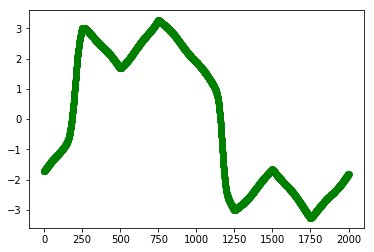

[ 256  750 1500]


,Point,Time (ms),Drive Voltage,Measured Polarization
250,251,25.1,296.0968,3.005339
251,252,25.2,291.8243,3.010365
252,253,25.3,296.5546,3.013380
253,254,25.4,288.2385,3.014553
254,255,25.5,290.8325,3.017735
255,256,25.6,289.9170,3.017233
256,257,25.7,286.7126,3.020416
257,258,25.8,288.5437,3.018573
258,259,25.9,281.2958,3.017735
259,260,26.0,283.7372,3.018238


In [7]:
# 提取出P值的plot,并且找到前两个peak，然后做差，即得出 delta P，which is from leakgae only
P_value = df['Measured Polarization']
plt.plot(P_value,'go--')
plt.show()
indices = find_peaks(P_value, prominence=1)[0]
print(indices)

df[250:260]

# 因为找到的峰不止一个，为了保险起见，我选择将图像分段，0-500和500-1000个点为区间，分别找peak

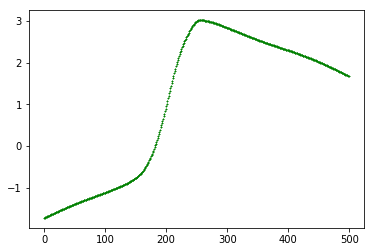

[256]


In [60]:
P_peak1 = P_value[0:500]
plt.plot(P_peak1, color='green', marker='+', linestyle='dashed',linewidth=0.1, markersize=2)
plt.show()
index1 = find_peaks(P_peak1, prominence = 1)[0]
print(index1)

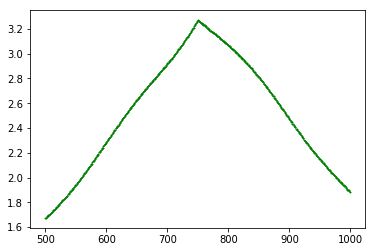

[750]


In [59]:
P_peak2 = P_value[500:1000]
plt.plot(P_peak2,color='green', marker='+', linestyle='dashed',linewidth=0.1, markersize=2)
plt.show()
index2 = find_peaks(P_peak2, prominence = 1)[0]+500  #要加上500，因为上一段有500个点
print(index2)

In [24]:
# print(type(index2))
# print(index2[0])
delta_P=df.ix[index2[0],'Measured Polarization']-df.ix[index1[0],'Measured Polarization']

print(type(delta_P))
print(delta_P)


<class 'numpy.float64'>
0.24943300000000024


[0. 1. 2. 3. 4. 5. 6.]
[ 0.   0.5  2.   4.5  8.  12.5 18. ]


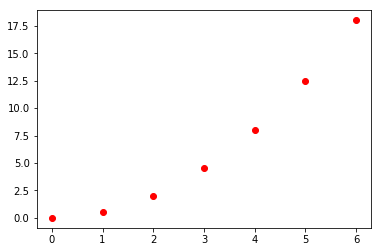

In [64]:
###cumulaive integral 的简单例子示范
x = np.linspace(0, 6, num=7)
print(x)
y = x
y_int = integrate.cumtrapz(y, x, initial=0)
print(y_int)
plt.plot(y_int, 'ro')
plt.show()

[ 0.00000000e+00 -4.84465000e-01 -1.09481500e+00 ... -8.94184320e+02
 -8.94867150e+02 -8.95408835e+02]


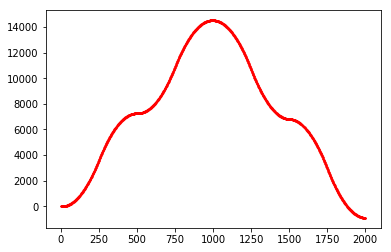

In [67]:
x = df['Time (ms)']
y = df['Drive Voltage']
y_integration = integrate.cumtrapz(y, x, initial=0)
print(y_integration)
plt.plot(y_integration, color='red', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
plt.show()

In [85]:
#插入voltage的积分这一列
df.insert(len(df.columns), "Voltage Integration", y_integaration)
df.head(10)

,Point,Time (ms),Drive Voltage,Measured Polarization,Voltage Integration
0,1,0.1,-2.5940,-1.721656,0.000000
1,2,0.2,-7.0953,-1.716463,-0.484465
2,3,0.3,-5.1117,-1.711270,-1.094815
3,4,0.4,-0.6104,-1.701722,-1.380920
4,5,0.5,-3.6621,-1.695691,-1.594545
5,6,0.6,2.4414,-1.687483,-1.655580
6,7,0.7,-2.1362,-1.678772,-1.640320
7,8,0.8,0.6104,-1.673914,-1.716610
8,9,0.9,7.0953,-1.666208,-1.331325
9,10,1.0,1.5259,-1.658837,-0.900265


In [80]:
#求出从peak1 到 peak2的voltage积分的差值
delta_V_integral = df.ix[index2[0],'Voltage Integration']-df.ix[index1[0],'Voltage Integration']
print(delta_V_integral)
one_over_AR = delta_P/delta_V_integral
print(one_over_AR)

7087.558785000005
3.5193076708992694e-05


In [86]:
#with 1/AR, Volta_integration x 1/AR = 单纯电阻对 P 的贡献
P_fromR  = df['Voltage Integration']*one_over_AR
df.insert(len(df.columns), "P from R", P_fromR)
#用测量的 P 减去 P from R，即得到 P without conduction
P_corrected = df['Measured Polarization']-df['P from R']
df.insert(len(df.columns), "Corrected P", P_corrected)
df.head(10)

,Point,Time (ms),Drive Voltage,Measured Polarization,Voltage Integration,P from R,Corrected P
0,1,0.1,-2.5940,-1.721656,0.000000,0.000000,-1.721656
1,2,0.2,-7.0953,-1.716463,-0.484465,-0.000017,-1.716446
2,3,0.3,-5.1117,-1.711270,-1.094815,-0.000039,-1.711231
3,4,0.4,-0.6104,-1.701722,-1.380920,-0.000049,-1.701673
4,5,0.5,-3.6621,-1.695691,-1.594545,-0.000056,-1.695635
5,6,0.6,2.4414,-1.687483,-1.655580,-0.000058,-1.687425
6,7,0.7,-2.1362,-1.678772,-1.640320,-0.000058,-1.678714
7,8,0.8,0.6104,-1.673914,-1.716610,-0.000060,-1.673854
8,9,0.9,7.0953,-1.666208,-1.331325,-0.000047,-1.666161
9,10,1.0,1.5259,-1.658837,-0.900265,-0.000032,-1.658805


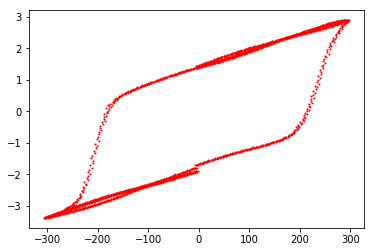

In [87]:
plt.plot(df['Drive Voltage'], df['Corrected P'], color='red', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
plt.show()

In [107]:
#剔除重叠的部分，删除500-1000行 以及 1500-2000行
P_positivepart= df.iloc[0:500]

P_negativepart= df.iloc[1000:1500]

New_df = P_positivepart.append(P_negativepart)
print(len(New_df))

1000


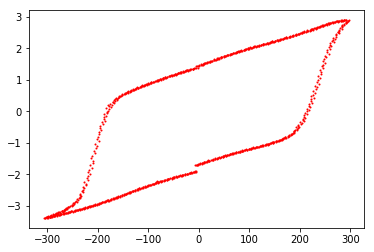

In [108]:
plt.plot(New_df['Drive Voltage'], New_df['Corrected P'], color='red', marker='o', linestyle='dashed',linewidth=0.1, markersize=1)
plt.show()

In [114]:
#r'C:\PhD-Zipeng\Research projects\PUND\1 - Copy.txt'
New_df.to_csv(r'C:\PhD-Zipeng\Research projects\PUND\1 modified.csv')

In [ ]:
#批量操作所有文件
# files = glob.glob(path + "/*.tab")
# files = glob(path + "/*.tab")